<a href="https://colab.research.google.com/github/frizzyboi1/BreastCancerDetection/blob/main/BreastCancerDetectionMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

import warnings
warnings.filterwarnings("ignore")

# survival
!pip install lifelines --quiet
from lifelines import KaplanMeierFitter, CoxPHFitter

sns.set(style="darkgrid", rc={"axes.facecolor": "#faded9"})
plt.rcParams["figure.dpi"] = 200


In [38]:
# adjust path as needed
df_raw = pd.read_csv("Breast Cancer METABRIC.csv")
df = df_raw.copy()

# clean column names
df.columns = (
    df.columns
      .str.strip()
      .str.replace('[^0-9a-zA-Z]+', '_', regex=True)
      .str.strip('_')
)

df.head()


,Patient_ID,Age_at_Diagnosis,Type_of_Breast_Surgery,Cancer_Type,Cancer_Type_Detailed,Cellularity,Chemotherapy,Pam50_Claudin_low_subtype,Cohort,ER_status_measured_by_IHC,...,Overall_Survival_Status,PR_Status,Radio_Therapy,Relapse_Free_Status_Months,Relapse_Free_Status,Sex,3_Gene_classifier_subtype,Tumor_Size,Tumor_Stage,Patient_s_Vital_Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [39]:
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Shape: (2509, 34)

Dtypes:
 Patient_ID                         object
Age_at_Diagnosis                  float64
Type_of_Breast_Surgery             object
Cancer_Type                        object
Cancer_Type_Detailed               object
Cellularity                        object
Chemotherapy                       object
Pam50_Claudin_low_subtype          object
Cohort                            float64
ER_status_measured_by_IHC          object
ER_Status                          object
Neoplasm_Histologic_Grade         float64
HER2_status_measured_by_SNP6       object
HER2_Status                        object
Tumor_Other_Histologic_Subtype     object
Hormone_Therapy                    object
Inferred_Menopausal_State          object
Integrative_Cluster                object
Primary_Tumor_Laterality           object
Lymph_nodes_examined_positive     float64
Mutation_Count                    float64
Nottingham_prognostic_index       float64
Oncotree_Code                      object
Overal

In [40]:
df = df.drop_duplicates().reset_index(drop=True)
print("After dropping duplicates:", df.shape)


After dropping duplicates: (2509, 34)


In [41]:
status_col = "Overall_Survival_Status"

df = df[df[status_col].notna()].copy()

status_map = {"Living": 0, "Deceased": 1}
df["target"] = df[status_col].map(status_map)

df["target"].value_counts()


,count
target,
1,1144
0,837


In [42]:
def get_feature_types(df, id_cols=("Patient_ID", "target")):
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    num_cols = [c for c in num_cols if c not in id_cols]

    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    cat_cols = [c for c in cat_cols if c not in id_cols and c not in id_cols]

    return num_cols, cat_cols

num_cols, cat_cols = get_feature_types(df)
num_cols, cat_cols


(['Age_at_Diagnosis',
  'Cohort',
  'Neoplasm_Histologic_Grade',
  'Lymph_nodes_examined_positive',
  'Mutation_Count',
  'Nottingham_prognostic_index',
  'Overall_Survival_Months',
  'Relapse_Free_Status_Months',
  'Tumor_Size',
  'Tumor_Stage'],
 ['Type_of_Breast_Surgery',
  'Cancer_Type',
  'Cancer_Type_Detailed',
  'Cellularity',
  'Chemotherapy',
  'Pam50_Claudin_low_subtype',
  'ER_status_measured_by_IHC',
  'ER_Status',
  'HER2_status_measured_by_SNP6',
  'HER2_Status',
  'Tumor_Other_Histologic_Subtype',
  'Hormone_Therapy',
  'Inferred_Menopausal_State',
  'Integrative_Cluster',
  'Primary_Tumor_Laterality',
  'Oncotree_Code',
  'Overall_Survival_Status',
  'PR_Status',
  'Radio_Therapy',
  'Relapse_Free_Status',
  'Sex',
  '3_Gene_classifier_subtype',
  'Patient_s_Vital_Status'])

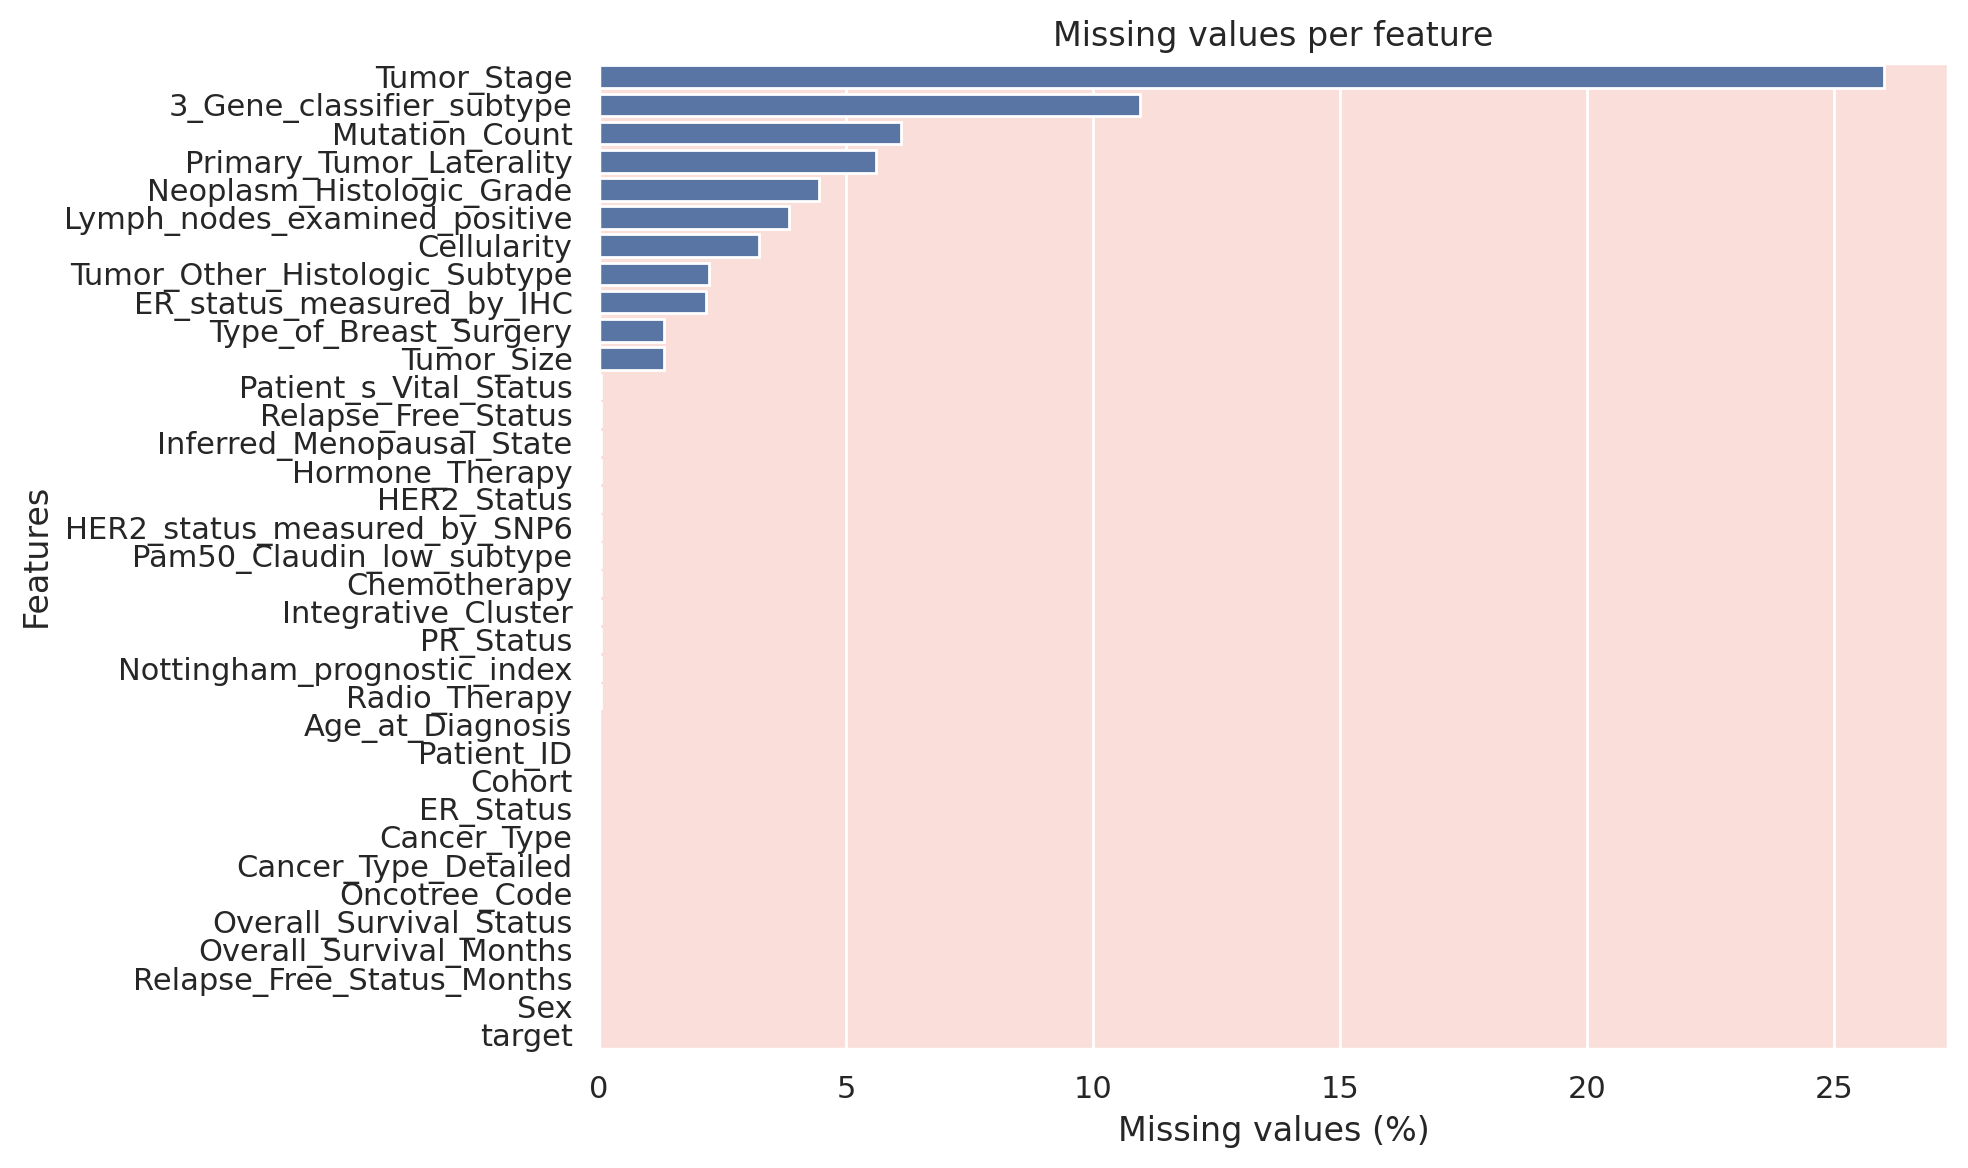

In [43]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_pct.values, y=missing_pct.index)
plt.xlabel("Missing values (%)")
plt.ylabel("Features")
plt.title("Missing values per feature")
plt.tight_layout()
plt.show()


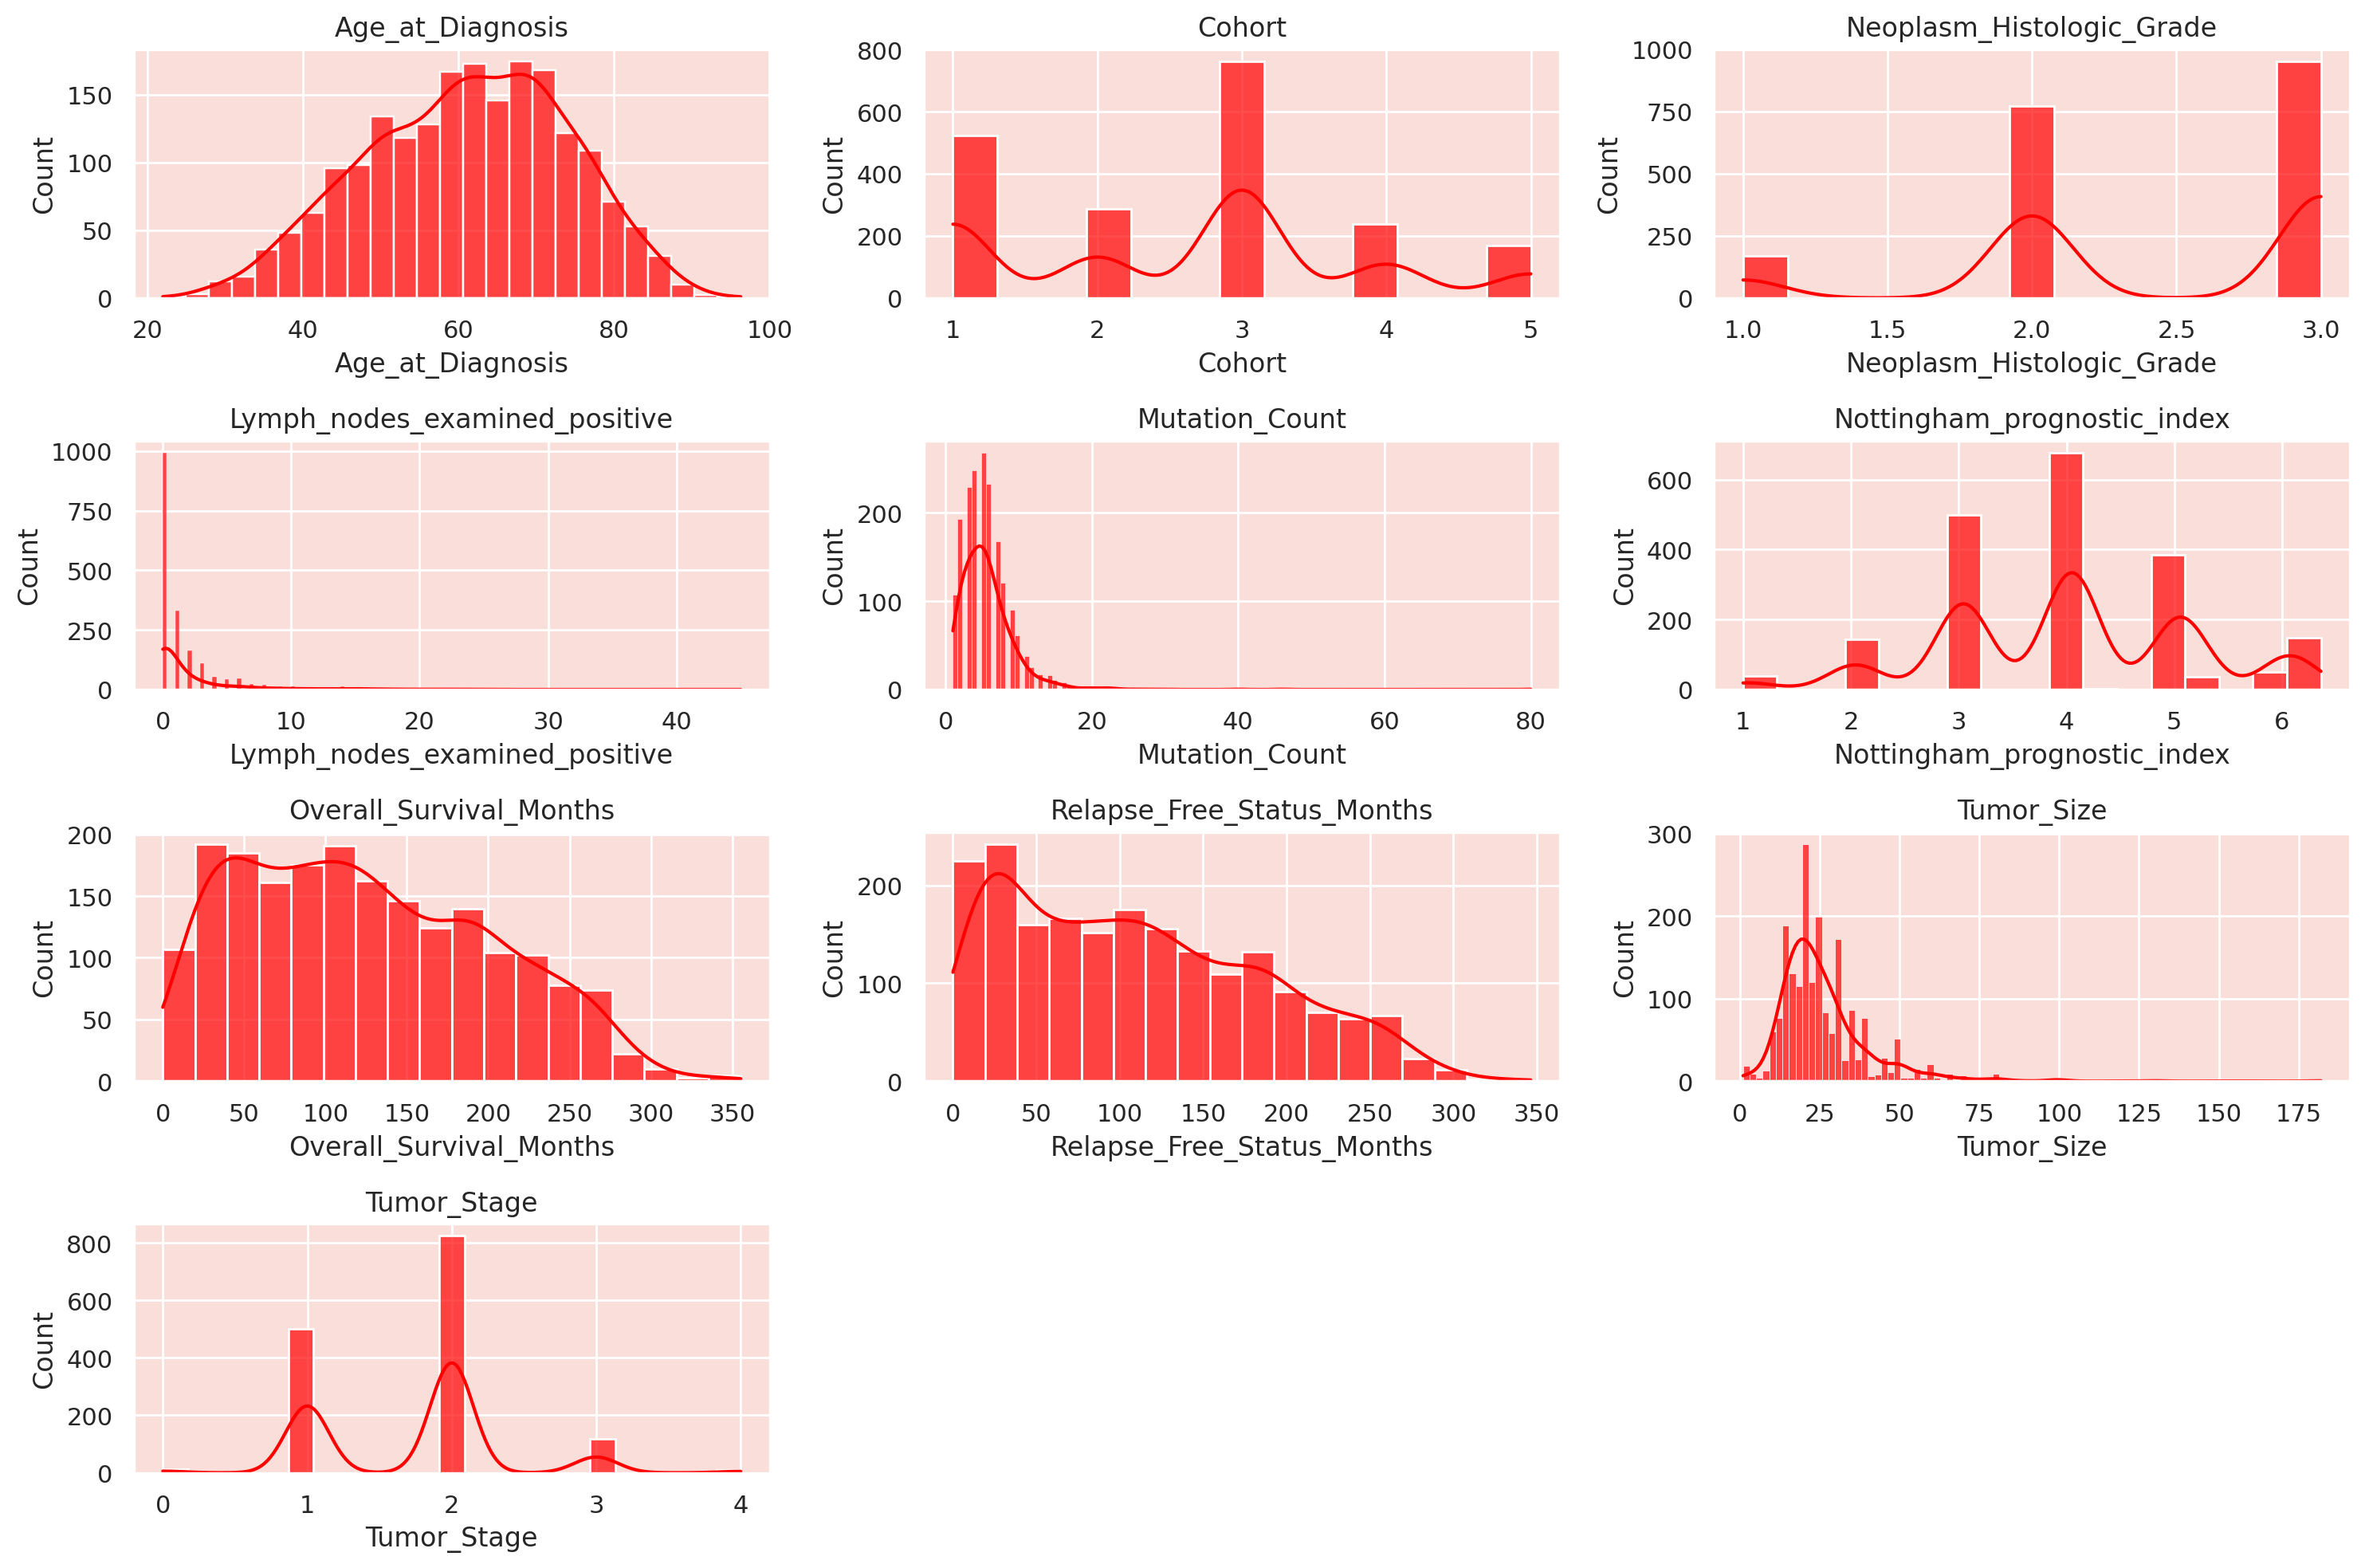

In [44]:
fig, ax = plt.subplots(nrows=int(np.ceil(len(num_cols)/3)), ncols=3, figsize=(15, 10))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=ax[i], color="red", alpha=0.7)
    ax[i].set_title(col)

for j in range(i+1, len(ax)):
    ax[j].axis("off")

plt.tight_layout()
plt.show()


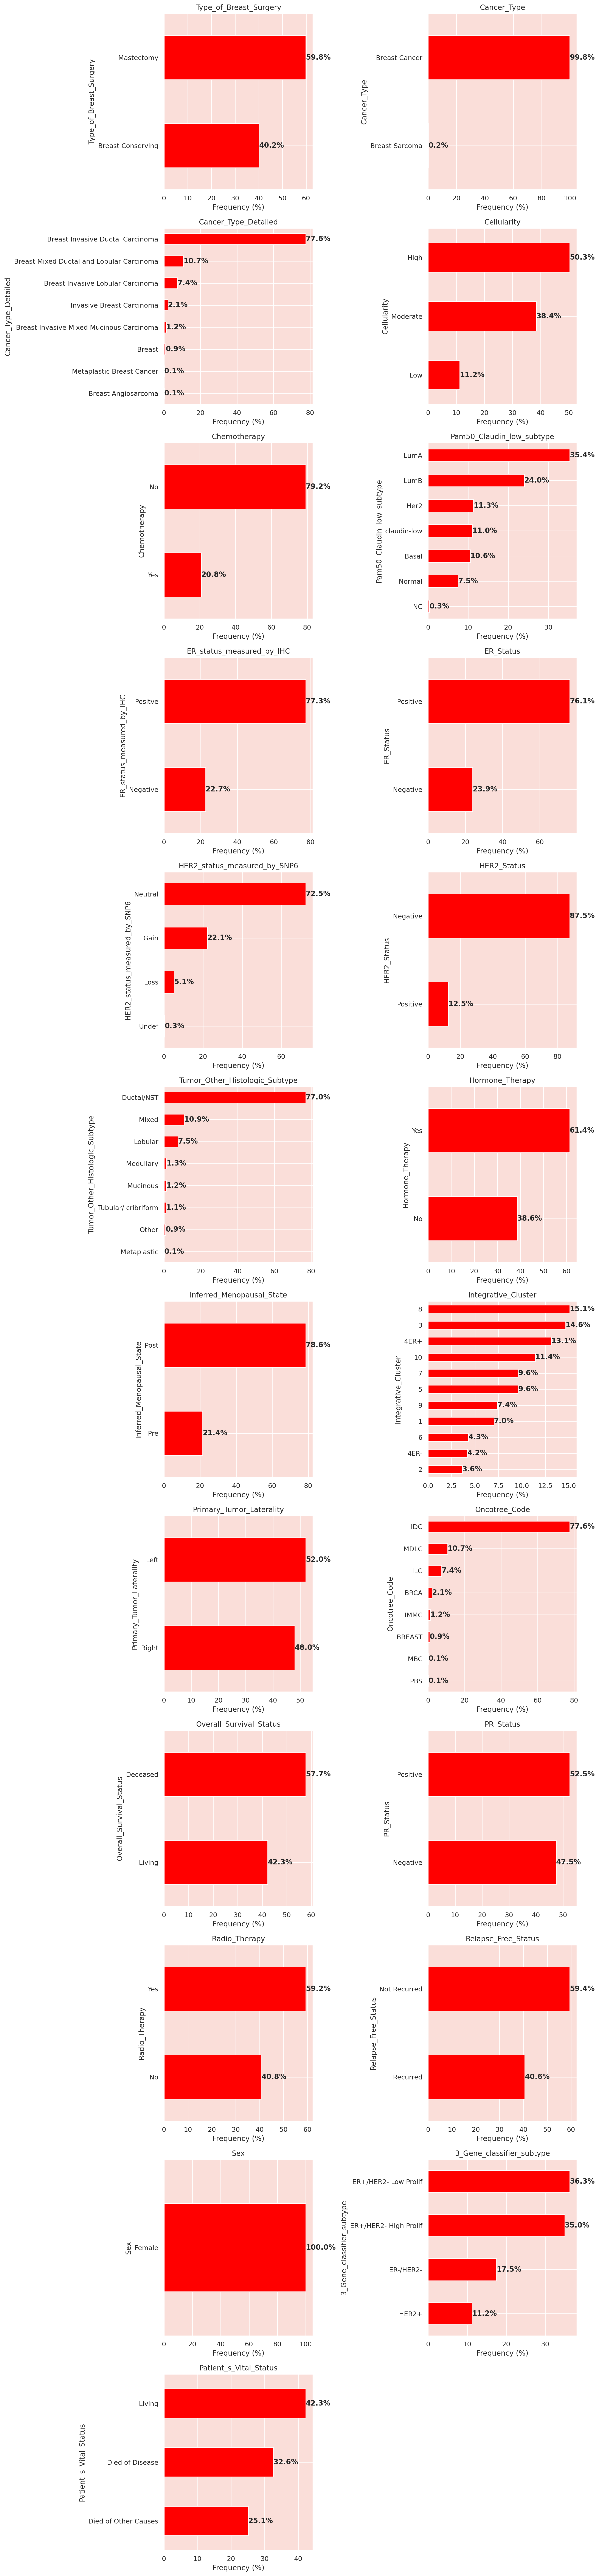

In [45]:
rows = int(np.ceil(len(cat_cols)/2))
fig, ax = plt.subplots(rows, 2, figsize=(14, 5*rows))
ax = ax.flatten()

for i, col in enumerate(cat_cols):
    vc = df[col].value_counts(normalize=True).mul(100).sort_values()
    vc.plot(kind="barh", ax=ax[i], color="red")
    ax[i].set_title(col)
    ax[i].set_xlabel("Frequency (%)")
    for idx, v in enumerate(vc.values):
        ax[i].text(v, idx, f"{v:.1f}%", va="center", fontweight="bold")
for j in range(i+1, len(ax)):
    ax[j].axis("off")

plt.tight_layout()
plt.show()


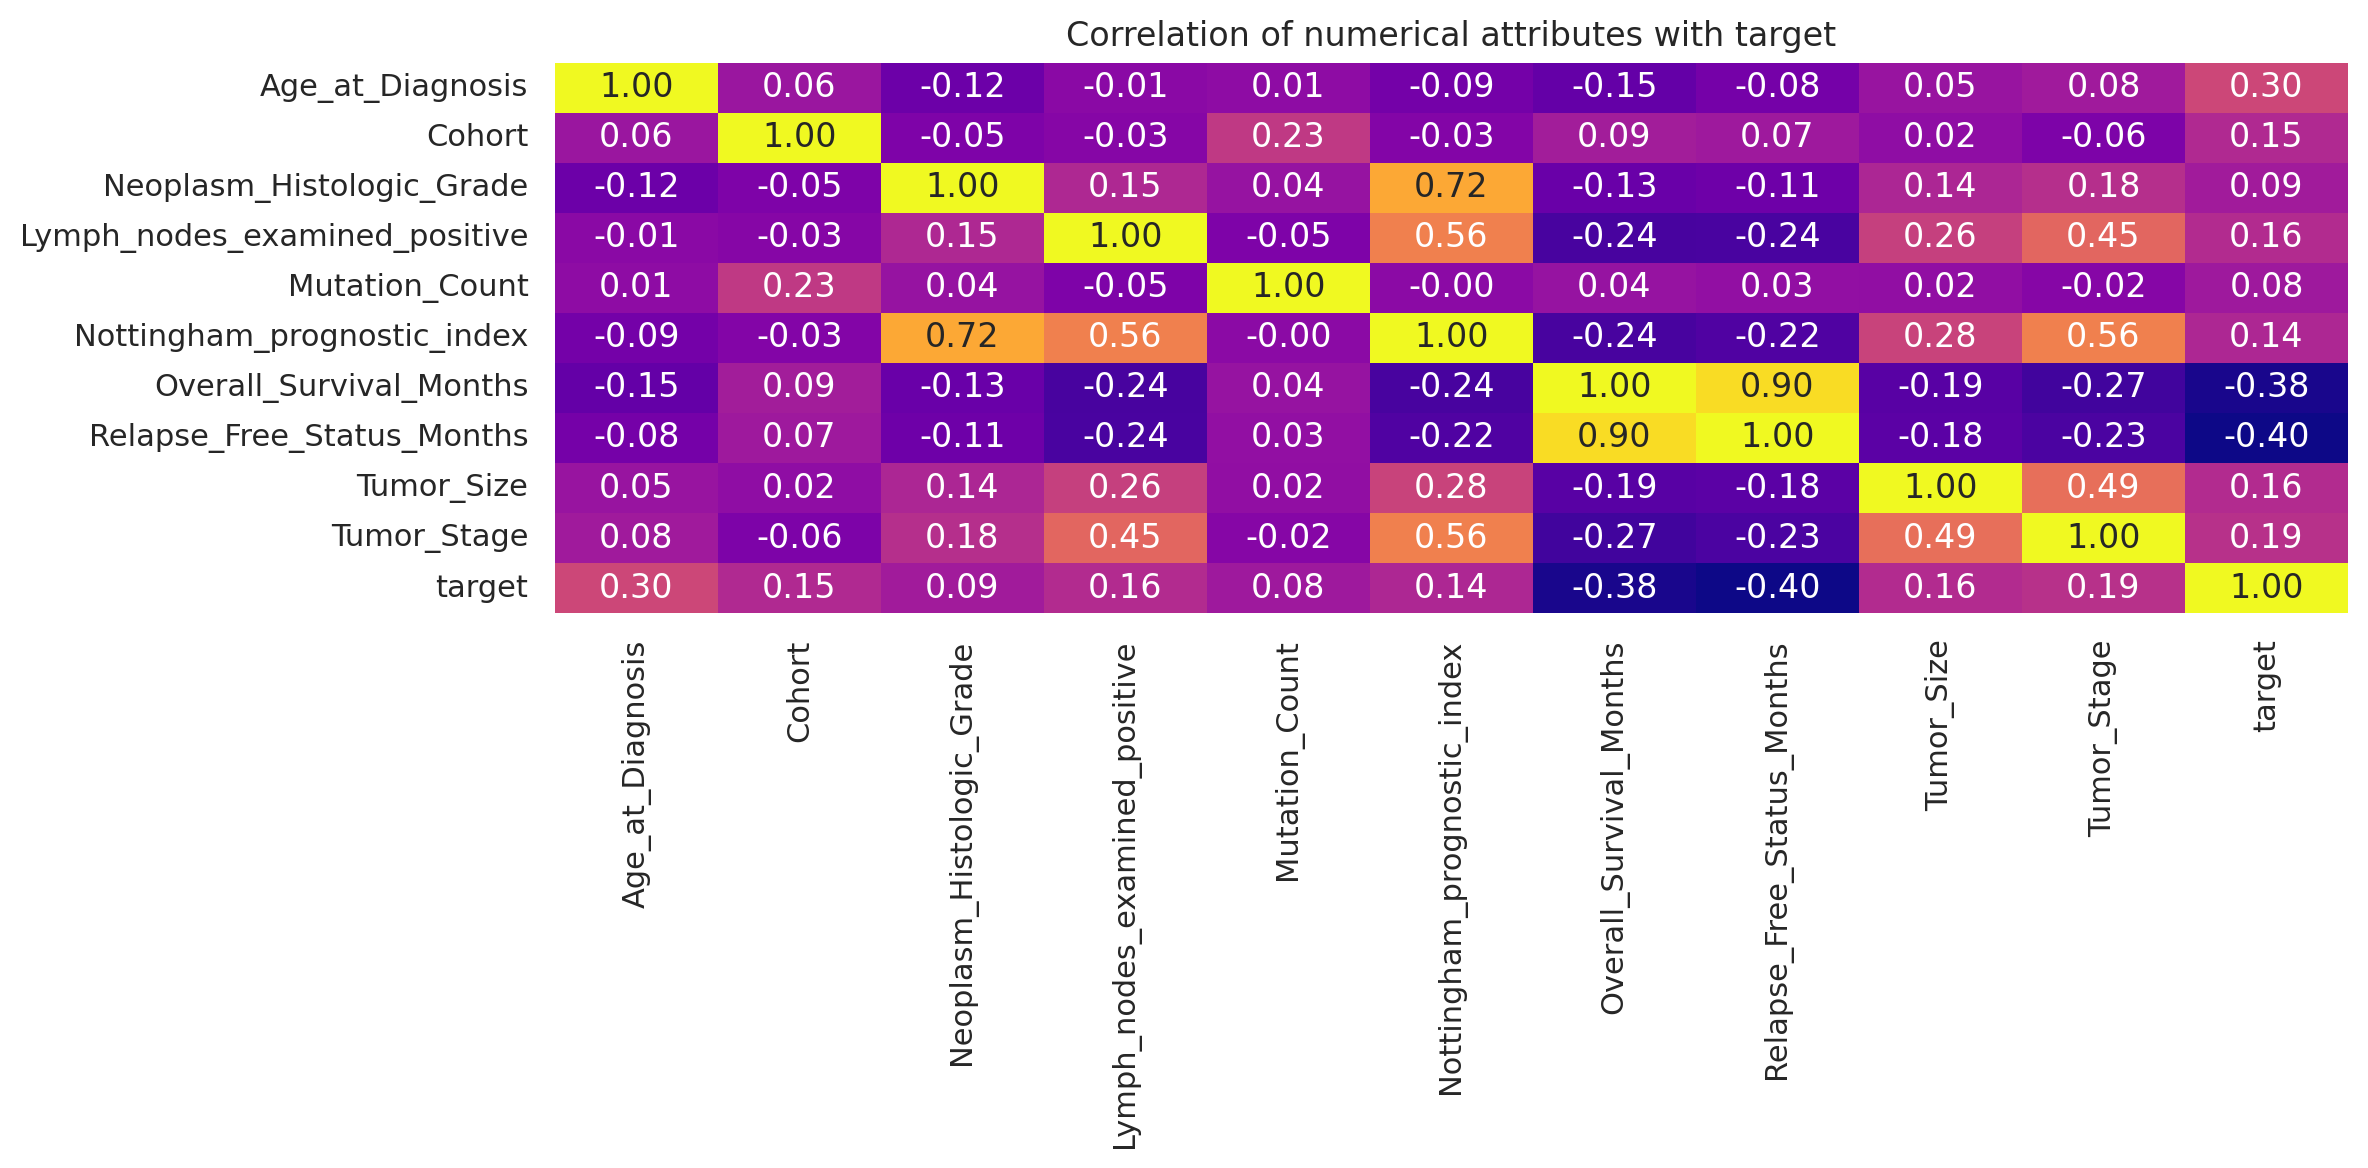

In [46]:
num_for_corr = num_cols + ["target"]
corr = df[num_for_corr].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, cmap="plasma", annot=True, fmt=".2f", cbar=False)
plt.title("Correlation of numerical attributes with target")
plt.tight_layout()
plt.show()


In [47]:
irrelevant_cols = ["Patient_ID", "Sex"]
df = df.drop(columns=[c for c in irrelevant_cols if c in df.columns], errors="ignore")


In [48]:
X = df.drop(columns=["target"])
y = df["target"].astype(int)


In [63]:
# Columns that leak the target and should NOT be used as features
leak_cols = [
    "Overall_Survival_Status",  # directly mapped to target
    "Overall_Survival_Months",  # survival time – strongly tied to status
    "Patient_s_Vital_Status",   # often same info with different naming
    "event",                    # if you created this for survival analysis
    "mortality_10yr"            # if present from earlier experiments
]

# Only drop columns that actually exist
leak_cols = [c for c in leak_cols if c in df.columns]

print("Dropping leakage columns:", leak_cols)

X = df.drop(columns=["target"] + leak_cols)
y = df["target"].astype(int)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)


Dropping leakage columns: ['Overall_Survival_Status', 'Overall_Survival_Months', 'Patient_s_Vital_Status']


In [64]:
X_train, X_test, scaler = preprocess_fit_transform(X_train_raw, X_test_raw)


In [65]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

X_train_raw.shape, X_test_raw.shape, y_train.value_counts(), y_test.value_counts()


((1584, 29),
 (397, 29),
 target
 1    915
 0    669
 Name: count, dtype: int64,
 target
 1    229
 0    168
 Name: count, dtype: int64)

In [66]:
# separate numeric / categorical on the raw train set
num_cols_train = X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_train = X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()

num_cols_train, cat_cols_train


(['Age_at_Diagnosis',
  'Cohort',
  'Neoplasm_Histologic_Grade',
  'Lymph_nodes_examined_positive',
  'Mutation_Count',
  'Nottingham_prognostic_index',
  'Relapse_Free_Status_Months',
  'Tumor_Size',
  'Tumor_Stage'],
 ['Type_of_Breast_Surgery',
  'Cancer_Type',
  'Cancer_Type_Detailed',
  'Cellularity',
  'Chemotherapy',
  'Pam50_Claudin_low_subtype',
  'ER_status_measured_by_IHC',
  'ER_Status',
  'HER2_status_measured_by_SNP6',
  'HER2_Status',
  'Tumor_Other_Histologic_Subtype',
  'Hormone_Therapy',
  'Inferred_Menopausal_State',
  'Integrative_Cluster',
  'Primary_Tumor_Laterality',
  'Oncotree_Code',
  'PR_Status',
  'Radio_Therapy',
  'Relapse_Free_Status',
  '3_Gene_classifier_subtype'])

In [67]:
def preprocess_fit_transform(X_train_raw, X_test_raw):
    X_train = X_train_raw.copy()
    X_test = X_test_raw.copy()

    num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

    # impute numeric with median
    num_imputer = SimpleImputer(strategy="median")
    X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
    X_test[num_cols] = num_imputer.transform(X_test[num_cols])

    # impute categorical with most frequent
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
    X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

    # one-hot encode categoricals
    X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

    # align columns
    X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

    # scale numeric columns (after dummies)
    num_cols_all = [c for c in X_train.columns if c in num_cols]

    scaler = StandardScaler()
    X_train[num_cols_all] = scaler.fit_transform(X_train[num_cols_all])
    X_test[num_cols_all] = scaler.transform(X_test[num_cols_all])

    return X_train, X_test, scaler

X_train, X_test, scaler = preprocess_fit_transform(X_train_raw, X_test_raw)
X_train.shape, X_test.shape


((1584, 66), (397, 66))

In [68]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best CV recall:", grid.best_score_)
    return grid.best_estimator_, grid.best_params_

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    rep = classification_report(y_test, y_pred, output_dict=True)

    metrics = {
        "precision_0": rep["0"]["precision"],
        "precision_1": rep["1"]["precision"],
        "recall_0": rep["0"]["recall"],
        "recall_1": rep["1"]["recall"],
        "f1_0": rep["0"]["f1-score"],
        "f1_1": rep["1"]["f1-score"],
        "macro_precision": rep["macro avg"]["precision"],
        "macro_recall": rep["macro avg"]["recall"],
        "macro_f1": rep["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }

    print(f"\n==== {name} ====")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    return pd.DataFrame(metrics, index=[name]).round(2)


In [69]:
log_clf = LogisticRegression(max_iter=1000)

param_grid_log = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear"]
}

best_log, best_log_params = tune_clf_hyperparameters(
    log_clf, param_grid_log, X_train, y_train, scoring="recall"
)

log_evaluation = evaluate_model(best_log, X_test, y_test, "LogisticRegression")
log_evaluation


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV recall: 0.8524590163934427

==== LogisticRegression ====
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       168
           1       0.80      0.85      0.83       229

    accuracy                           0.79       397
   macro avg       0.79      0.78      0.79       397
weighted avg       0.79      0.79      0.79       397

Confusion matrix:
 [[121  47]
 [ 35 194]]


,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_precision,macro_recall,macro_f1,accuracy
LogisticRegression,0.78,0.8,0.72,0.85,0.75,0.83,0.79,0.78,0.79,0.79


In [70]:
dt_clf = DecisionTreeClassifier(random_state=0)

param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 3, 4, 6, None],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3]
}

best_dt, best_dt_params = tune_clf_hyperparameters(
    dt_clf, param_grid_dt, X_train, y_train, scoring="recall"
)

dt_evaluation = evaluate_model(best_dt, X_test, y_test, "DecisionTree")
dt_evaluation


Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best params: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV recall: 0.8918032786885245

==== DecisionTree ====
              precision    recall  f1-score   support

           0       0.85      0.63      0.72       168
           1       0.77      0.92      0.84       229

    accuracy                           0.80       397
   macro avg       0.81      0.77      0.78       397
weighted avg       0.80      0.80      0.79       397

Confusion matrix:
 [[106  62]
 [ 19 210]]


,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_precision,macro_recall,macro_f1,accuracy
DecisionTree,0.85,0.77,0.63,0.92,0.72,0.84,0.81,0.77,0.78,0.8


In [71]:
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 6, 10],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False]
}

best_rf, best_rf_params = tune_clf_hyperparameters(
    rf_clf, param_grid_rf, X_train, y_train, scoring="recall"
)

rf_evaluation = evaluate_model(best_rf, X_test, y_test, "RandomForest")
rf_evaluation


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV recall: 0.8797814207650273

==== RandomForest ====
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       168
           1       0.82      0.87      0.85       229

    accuracy                           0.82       397
   macro avg       0.81      0.81      0.81       397
weighted avg       0.82      0.82      0.81       397

Confusion matrix:
 [[125  43]
 [ 30 199]]


,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_precision,macro_recall,macro_f1,accuracy
RandomForest,0.81,0.82,0.74,0.87,0.77,0.85,0.81,0.81,0.81,0.82


In [72]:
svm_clf = SVC(probability=True, random_state=0)

param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

best_svm, best_svm_params = tune_clf_hyperparameters(
    svm_clf, param_grid_svm, X_train, y_train, scoring="recall"
)

svm_evaluation = evaluate_model(best_svm, X_test, y_test, "SVM")
svm_evaluation


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'C': 0.1, 'kernel': 'rbf'}
Best CV recall: 0.8710382513661203

==== SVM ====
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       168
           1       0.79      0.85      0.82       229

    accuracy                           0.78       397
   macro avg       0.78      0.77      0.77       397
weighted avg       0.78      0.78      0.78       397

Confusion matrix:
 [[116  52]
 [ 35 194]]


,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_precision,macro_recall,macro_f1,accuracy
SVM,0.77,0.79,0.69,0.85,0.73,0.82,0.78,0.77,0.77,0.78


In [73]:
results = pd.concat([log_evaluation, dt_evaluation, rf_evaluation, svm_evaluation])
results = results.sort_values(by="recall_1", ascending=False)
results


,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_precision,macro_recall,macro_f1,accuracy
DecisionTree,0.85,0.77,0.63,0.92,0.72,0.84,0.81,0.77,0.78,0.80
RandomForest,0.81,0.82,0.74,0.87,0.77,0.85,0.81,0.81,0.81,0.82
LogisticRegression,0.78,0.80,0.72,0.85,0.75,0.83,0.79,0.78,0.79,0.79
SVM,0.77,0.79,0.69,0.85,0.73,0.82,0.78,0.77,0.77,0.78


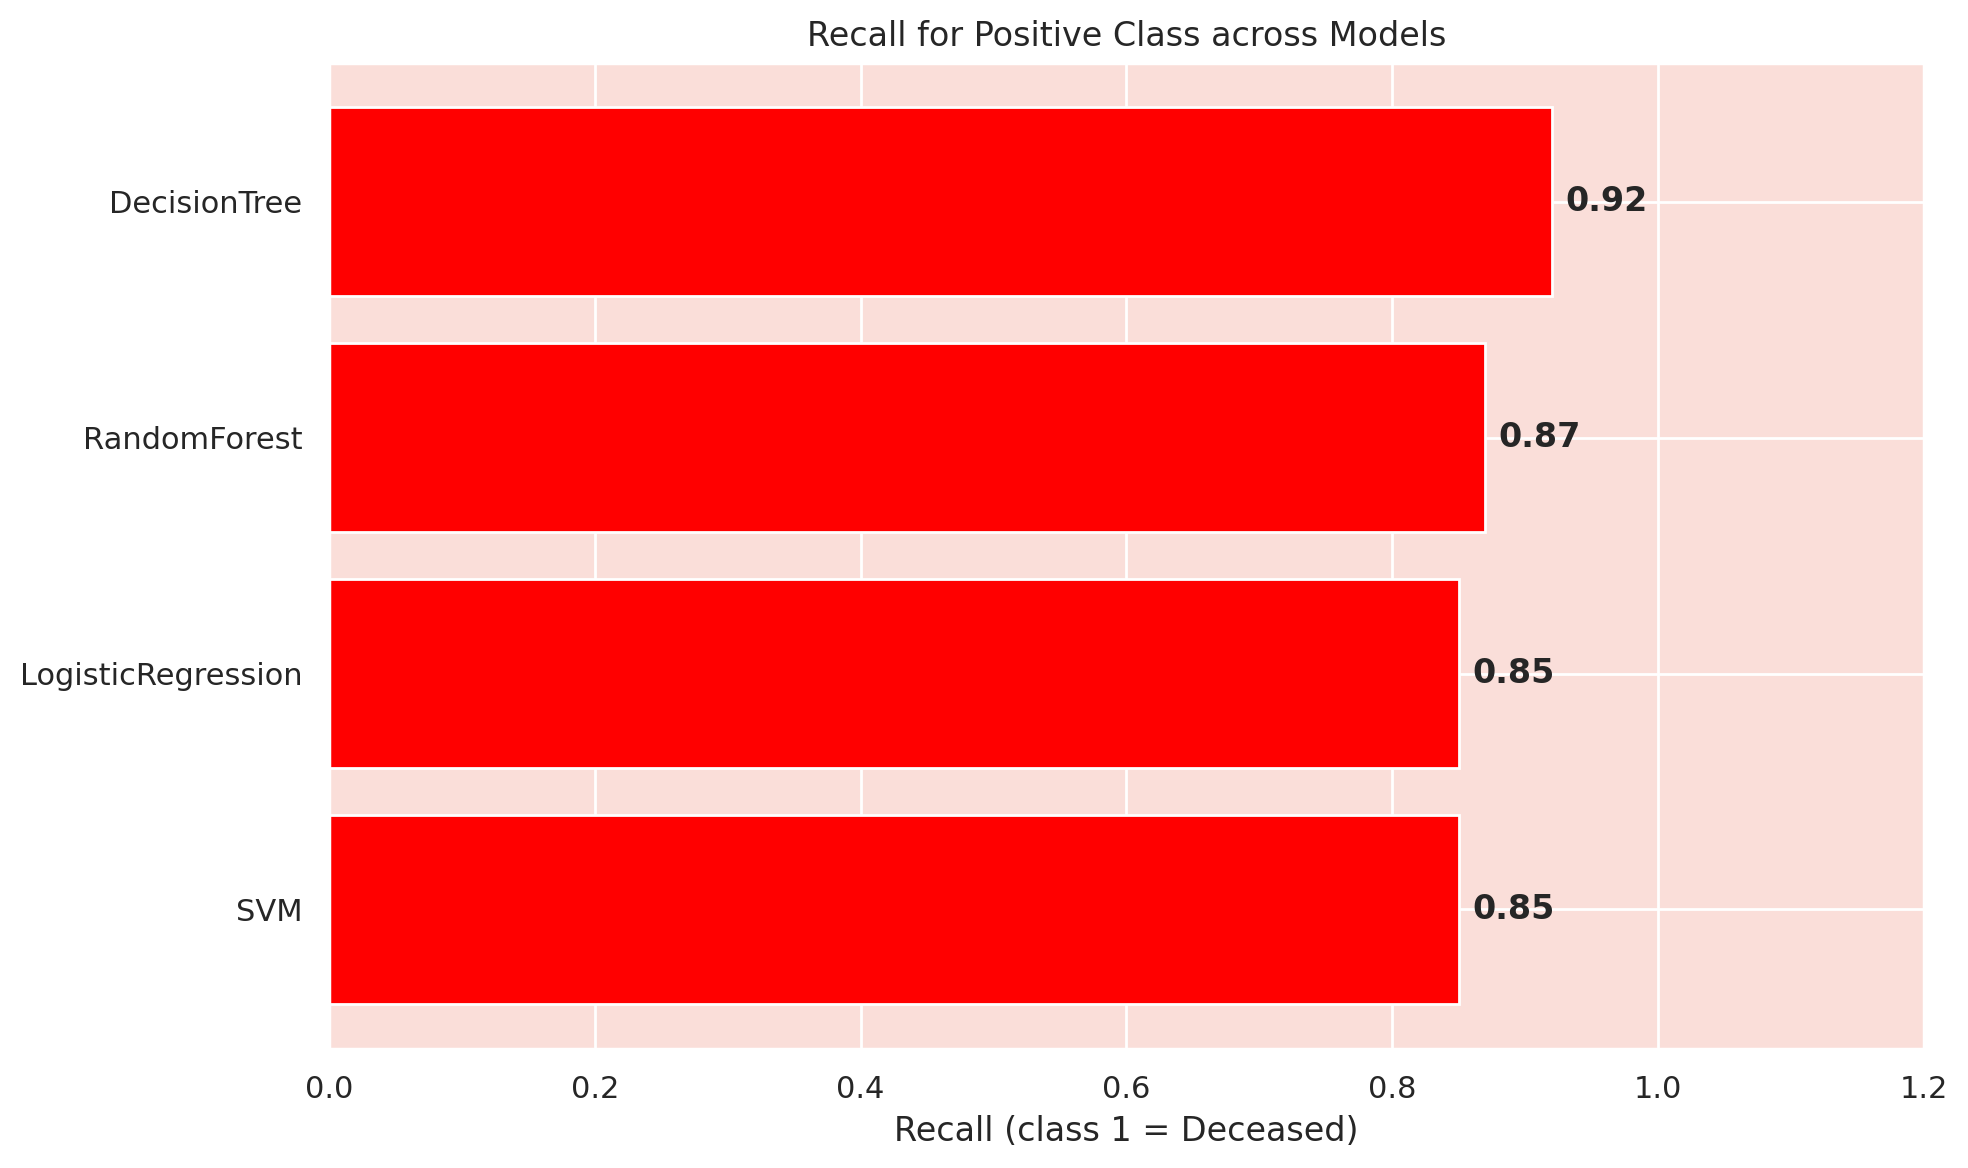

In [74]:
results_sorted = results.sort_values(by="recall_1", ascending=True)
recall_scores = results_sorted["recall_1"]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(results_sorted.index, recall_scores, color="red")

for i, (val, name) in enumerate(zip(recall_scores, results_sorted.index)):
    ax.text(val + 0.01, i, f"{val:.2f}", va="center", fontweight="bold")

ax.set_xlim(0, 1.2)
ax.set_xlabel("Recall (class 1 = Deceased)")
ax.set_title("Recall for Positive Class across Models")
plt.tight_layout()
plt.show()


In [75]:
# we re-use df with original survival columns
df_surv = df_raw.copy()
df_surv.columns = (
    df_surv.columns
      .str.strip()
      .str.replace('[^0-9a-zA-Z]+', '_', regex=True)
      .str.strip('_')
)

df_surv = df_surv[df_surv["Overall_Survival_Months"].notna() & df_surv["Overall_Survival_Status"].notna()].copy()
status_map = {"Deceased": 1, "Living": 0}
df_surv["event"] = df_surv["Overall_Survival_Status"].map(status_map)


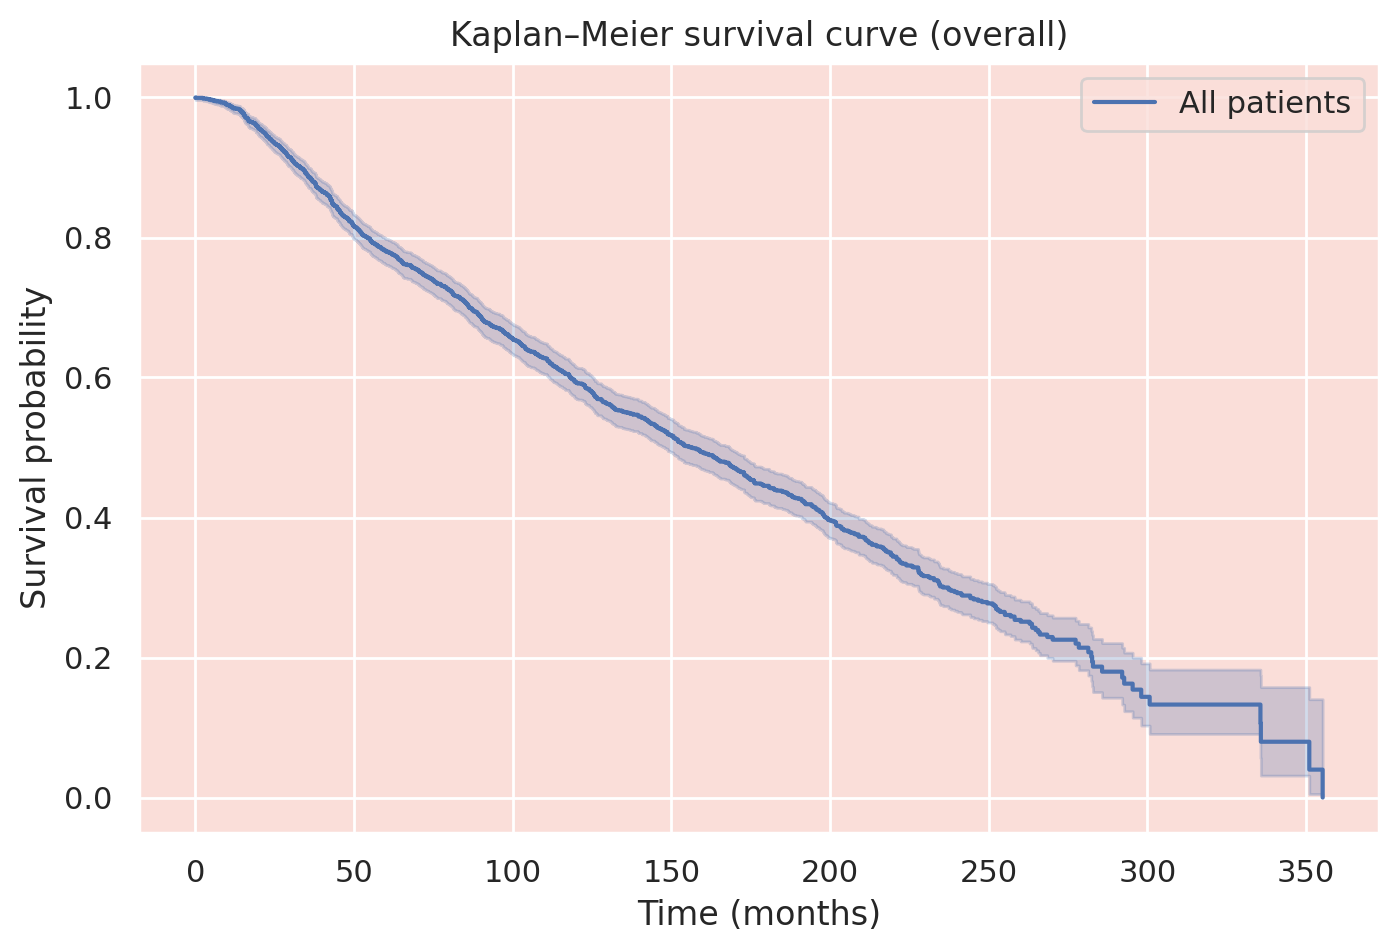

In [76]:
kmf = KaplanMeierFitter()

T = df_surv["Overall_Survival_Months"]
E = df_surv["event"]

kmf.fit(T, event_observed=E, label="All patients")
kmf.plot()
plt.xlabel("Time (months)")
plt.ylabel("Survival probability")
plt.title("Kaplan–Meier survival curve (overall)")
plt.show()


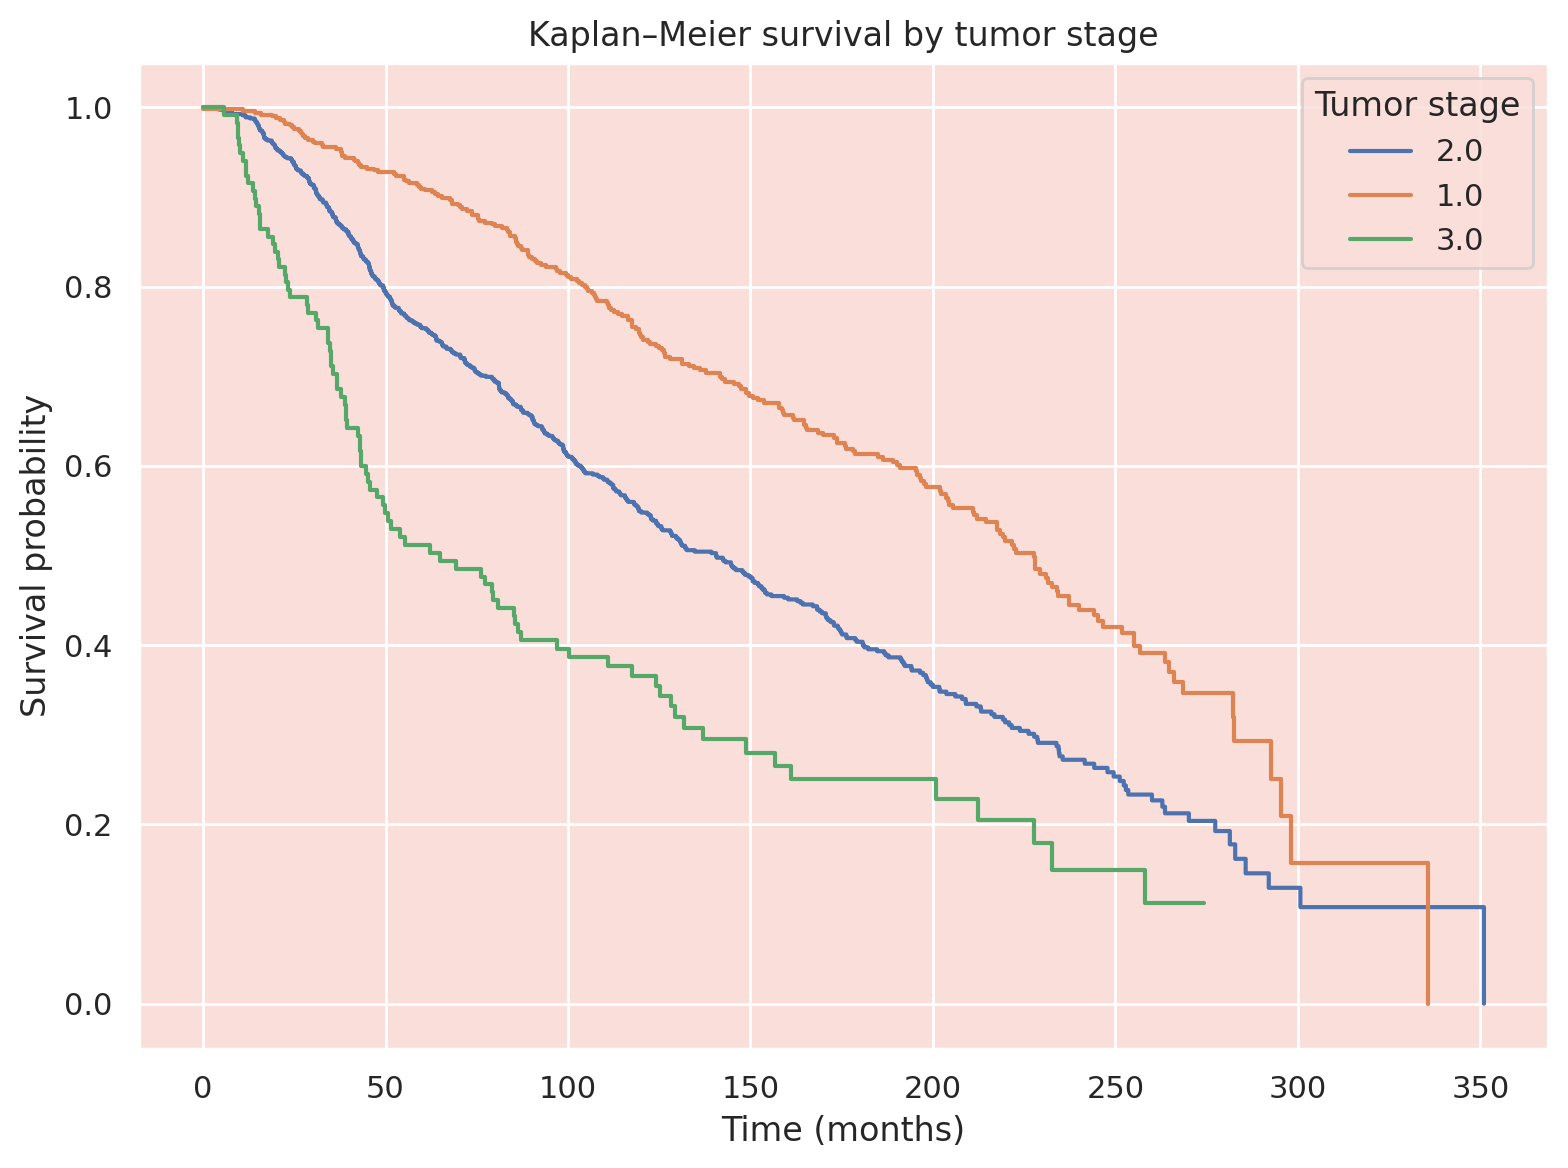

In [77]:
if "Tumor_Stage" in df_surv.columns:
    plt.figure(figsize=(8, 6))
    kmf = KaplanMeierFitter()
    for stage in df_surv["Tumor_Stage"].dropna().unique():
        mask = df_surv["Tumor_Stage"] == stage
        T_stage = df_surv.loc[mask, "Overall_Survival_Months"]
        E_stage = df_surv.loc[mask, "event"]
        if len(T_stage) < 20:
            continue
        kmf.fit(T_stage, event_observed=E_stage, label=str(stage))
        kmf.plot(ci_show=False)
    plt.xlabel("Time (months)")
    plt.ylabel("Survival probability")
    plt.title("Kaplan–Meier survival by tumor stage")
    plt.legend(title="Tumor stage")
    plt.tight_layout()
    plt.show()


<lifelines.CoxPHFitter: fitted with 1354 total observations, 596 right-censored observations>
             duration col = 'Overall_Survival_Months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1354
number of events observed = 758
   partial log-likelihood = -4798.71
         time fit was run = 2025-12-09 19:52:23 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Age_at_Diagnosis               0.04      1.04      0.00            0.03            0.04                1.03                1.05
Tumor_Size                     0.01      1.01      0.00            0.00            0.01                1.00                1.01
Lymph_nodes_examined_positive  0.06      1.06      0.01            0.04            0.07                1.04                1.08
Neoplasm_Histologic_Grade      0.16      1.17      0.06            0.04            0.28                1.04                1.32
Tumor_Stage                    0.21      1.24      0.07            0.07            0.35                1.07                1.42
Chemotherapy_Yes               0.26      1.30      0.11            0.04            0.49                1.04                1.63

                               cmp to     z      p  -log2(p)
covariate                                                   
Age_at_Diagnosis                 0.00 10.41 <0.005     81.96
Tumor_Size                       0.00  3.15 <0.005      9.27
Lymph_nodes_examined_positive    0.00  5.93 <0.005     28.34
Neoplasm_Histologic_Grade        0.00  2.55   0.01      6.55
Tumor_Stage                      0.00  2.92 <0.005      8.18
Chemotherapy_Yes                 0.00  2.29   0.02      5.49
---
Concordance = 0.67
Partial AIC = 9609.42
log-likelihood ratio test = 280.34 on 6 df
-log2(p) of ll-ratio test = 188.94

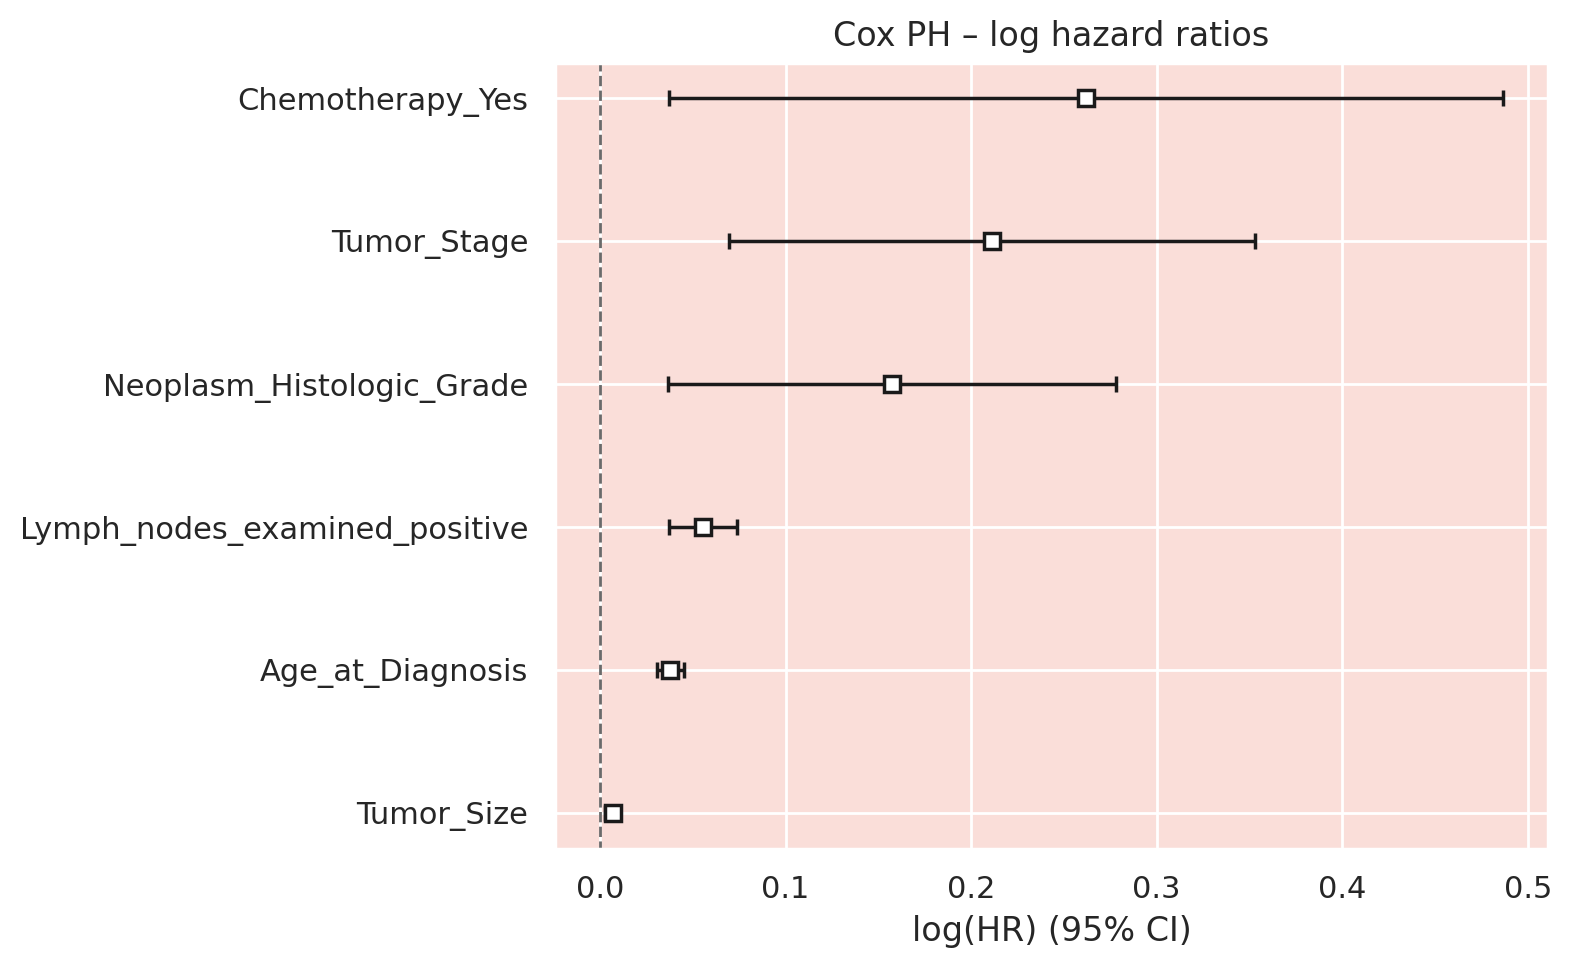

In [78]:
cox_features = [
    "Age_at_Diagnosis",
    "Tumor_Size",
    "Chemotherapy",
    "Lymph_nodes_examined_positive",
    "Neoplasm_Histologic_Grade",
    "Tumor_Stage"
]
cox_features = [c for c in cox_features if c in df_surv.columns]

df_cox = df_surv[["Overall_Survival_Months", "event"] + cox_features].dropna().copy()

cat_cols_cox = df_cox.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols_cox = [c for c in cat_cols_cox if c not in ["Overall_Survival_Months", "event"]]

df_cox = pd.get_dummies(df_cox, columns=cat_cols_cox, drop_first=True)

cph = CoxPHFitter()
cph.fit(df_cox, duration_col="Overall_Survival_Months", event_col="event")
cph.print_summary()
cph.plot()
plt.title("Cox PH – log hazard ratios")
plt.tight_layout()
plt.show()
